In [2]:
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.5 MB/s eta 0:00:00


In [3]:
import os
import sys
import cv2
import math
import umap
import shutil
import random
import imutils
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn

from tqdm import tqdm
from PIL import Image
from os import listdir

from tensorflow.keras import layers
from plotly import tools
from random import shuffle
from itertools import chain
from numpy import expand_dims
from matplotlib import pyplot
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from collections import Counter
from os.path import isfile, join
from sklearn.manifold import TSNE
from skimage.transform import resize
from skimage.morphology import label
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.metrics import recall_score
from sklearn.datasets import make_circles
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import precision_score
from tensorflow.keras.layers import Dropout, Lambda
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode, iplot
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from skimage.io import imread, imshow, imread_collection, concatenate_images
import tensorflow.keras.layers as L

2025-05-28 17:11:54.565003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748452314.752857      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748452314.807069      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Loading and split

In [17]:
random.seed(42)  # for reproducibility

IMG_PATH = '/kaggle/input/brain-tumor-detection'

# Clean old directories
for folder in ['TRAIN', 'VAL', 'TEST']:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# Create new ones
for folder in ['TRAIN', 'VAL', 'TEST']:
    for label in ['YES', 'NO']:
        os.makedirs(os.path.join(folder, label), exist_ok=True)

# Shuffle and split for both classes
for CLASS in ['yes', 'no']:
    class_path = os.path.join(IMG_PATH, CLASS)
    IMG_FILES = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    random.shuffle(IMG_FILES)
    print(f'{len(IMG_FILES)} images found in class "{CLASS}"')

    for n, FILE_NAME in enumerate(IMG_FILES):
        src = os.path.join(class_path, FILE_NAME)
        if n < 200:
            dst = os.path.join('TEST', CLASS.upper(), FILE_NAME)
        elif n < 1200:
            dst = os.path.join('TRAIN', CLASS.upper(), FILE_NAME)
        else:
            dst = os.path.join('VAL', CLASS.upper(), FILE_NAME)
        
        shutil.copy(src, dst)


1500 images found in class "yes"
1500 images found in class "no"


In [18]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img_path = os.path.join(dir_path, path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)  
                        X.append(img)
                        y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [19]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


2000 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


400 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

600 images loaded from VAL/ directory.


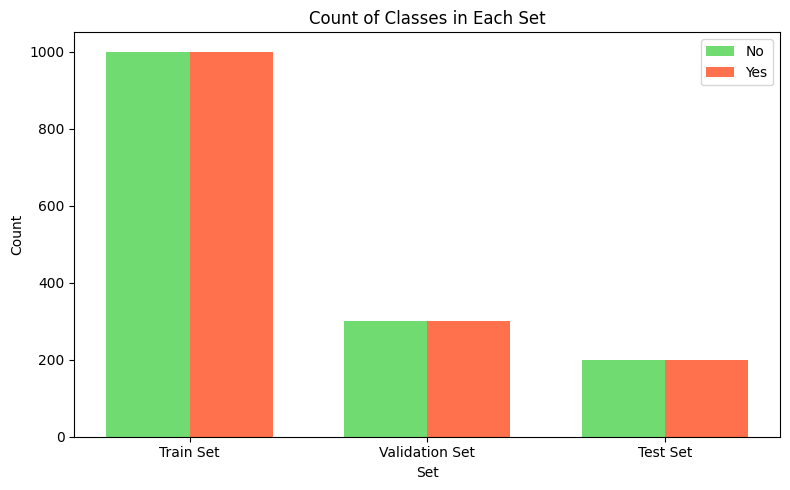

In [10]:
y = dict()
y[0] = []
y[1] = []

for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

set_labels = ['Train Set', 'Validation Set', 'Test Set']
x = np.arange(len(set_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, y[0], width, label='No', color='#33cc33', alpha=0.7)
bar2 = ax.bar(x + width/2, y[1], width, label='Yes', color='#ff3300', alpha=0.7)

# Labeling
ax.set_title('Count of Classes in Each Set')
ax.set_xlabel('Set')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(set_labels)
ax.legend()

plt.tight_layout()
plt.show()


In [11]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,4))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

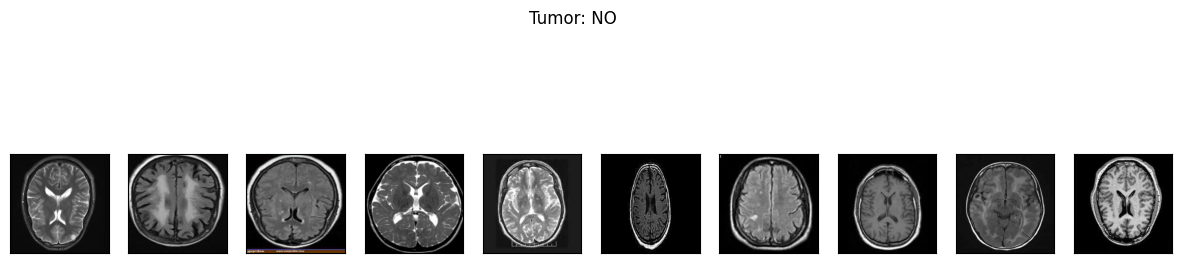

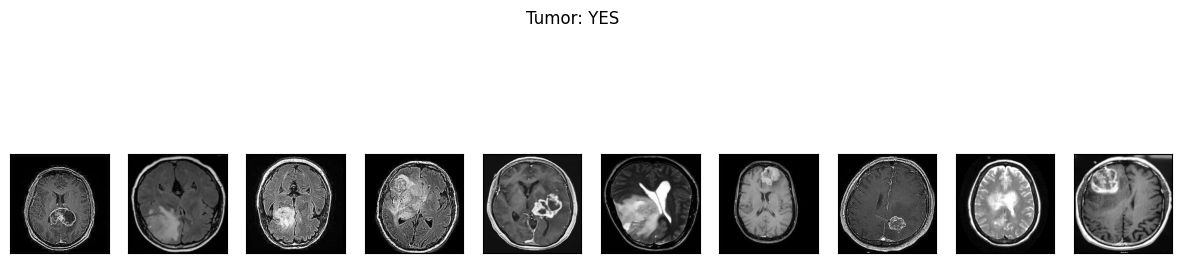

In [12]:
plot_samples(X_train, y_train, labels, 10)

# Data preprocessing

# normalization

In [20]:
def crop_imgs(set_name, add_pixels_value=0, resize_to=(224, 224)):
    """
    Crop around the extreme points of the image and resize to a fixed size.
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Binary thresholding
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if len(cnts) == 0:
            set_new.append(cv2.resize(img, resize_to))  # fallback to resizing the full image
            continue

        c = max(cnts, key=cv2.contourArea)

        # Find extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Add pixels and crop
        ADD_PIXELS = add_pixels_value
        cropped = img[max(0, extTop[1] - ADD_PIXELS): extBot[1] + ADD_PIXELS,
                      max(0, extLeft[0] - ADD_PIXELS): extRight[0] + ADD_PIXELS]

        # Resize to fixed size
        resized = cv2.resize(cropped, resize_to)
        set_new.append(resized)
    
    return np.array(set_new)

In [21]:
img = cv2.imread('/kaggle/input/brain-tumor-detection/yes/y66.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

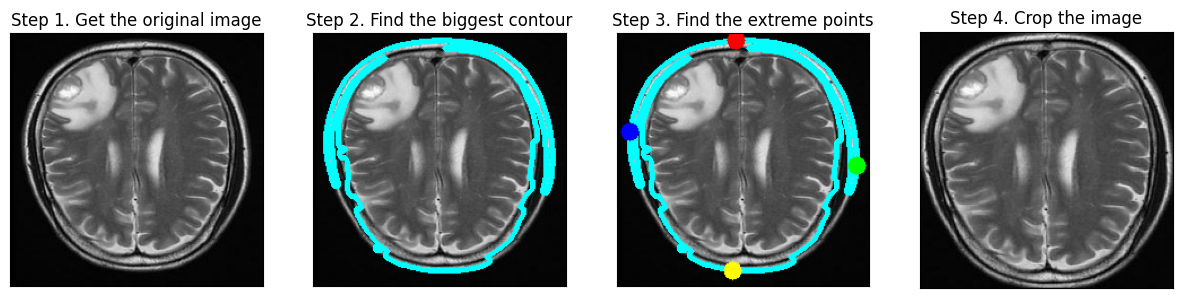

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [22]:
X_train_crop = crop_imgs(X_train)
X_val_crop = crop_imgs(X_val)
X_test_crop = crop_imgs(X_test)

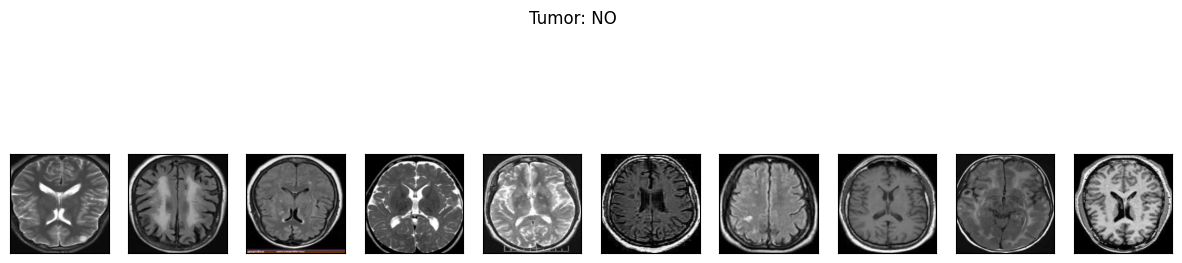

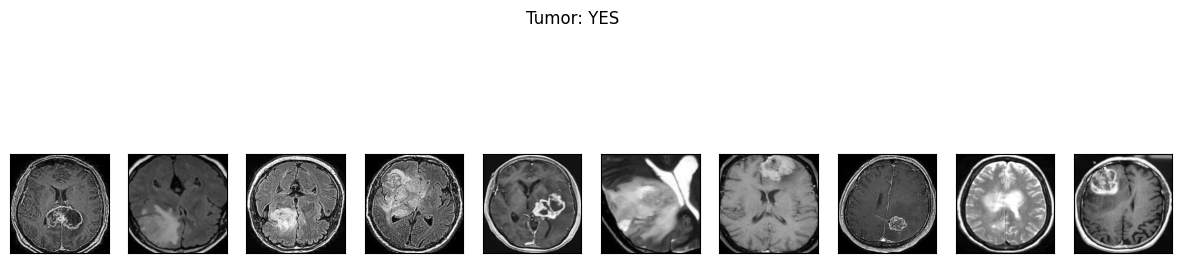

In [18]:
plot_samples(X_train_crop, y_train, labels, 10)

In [23]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [24]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [25]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [26]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

# Augmentation

In [27]:
RANDOM_SEED = 42

TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary',
    seed=RANDOM_SEED,
    shuffle=True
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# EB2

In [19]:
def build_lrfn(lr_start=0.0005, lr_max=0.001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [20]:
import tensorflow.keras.layers as L
NUM_CLASSES = 1

efficientnet = tf.keras.Sequential([
    efn.EfficientNetB2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
    ])
        
efficientnet.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)
    
efficientnet.summary()

I0000 00:00:1748410707.593244      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


31936256/31936256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnet-b2 (Functional)         │ (None, 7, 7, 1408)          │       7,768,562 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 1408)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,769,971 (29.64 MB)

 Trainable params: 7,702,403 (29.38 MB)

 Non-trainable params: 67,568 (263.94 KB)

In [21]:
import time

start = time.time()

efficientnet_history = efficientnet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)


end = time.time()
print(end - start)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/20


I0000 00:00:1748410789.248897     123 service.cc:148] XLA service 0x79ad54002800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748410789.249708     123 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748410795.816894     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748410809.015276     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748410809.211849     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748410809.791283     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748410810.0052

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.7800 - loss: 1.0017

E0000 00:00:1748410873.505850     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748410873.693594     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748410874.148133     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748410874.357587     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748410874.715584     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

32/32 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.7870 - loss: 0.9671 - val_accuracy: 0.7792 - val_loss: 1.1916
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 708ms/step - accuracy: 0.9834 - loss: 0.0730 - val_accuracy: 0.8292 - val_loss: 1.2016
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 702ms/step - accuracy: 0.9827 - loss: 0.0718 - val_accuracy: 0.9792 - val_loss: 0.1489
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 716ms/step - accuracy: 0.9961 - loss: 0.0257 - val_accuracy: 0.9750 - val_loss: 0.1359
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 696ms/step - accuracy: 0.9937 - loss: 0.0169 - val_accuracy: 0.9937 - val_loss: 0.1337
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 712ms/step - accuracy: 0.9921 - loss: 0.0194 - val_accuracy: 0.9812 - val_loss: 0.1513
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 704ms/step - accuracy: 0.9947 - loss: 0.0149 - val_accuracy: 0.9937 - val_loss: 0.0868
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 730ms/step - accuracy: 0.9914 - loss: 0.0223 - val_accuracy: 0.9917 

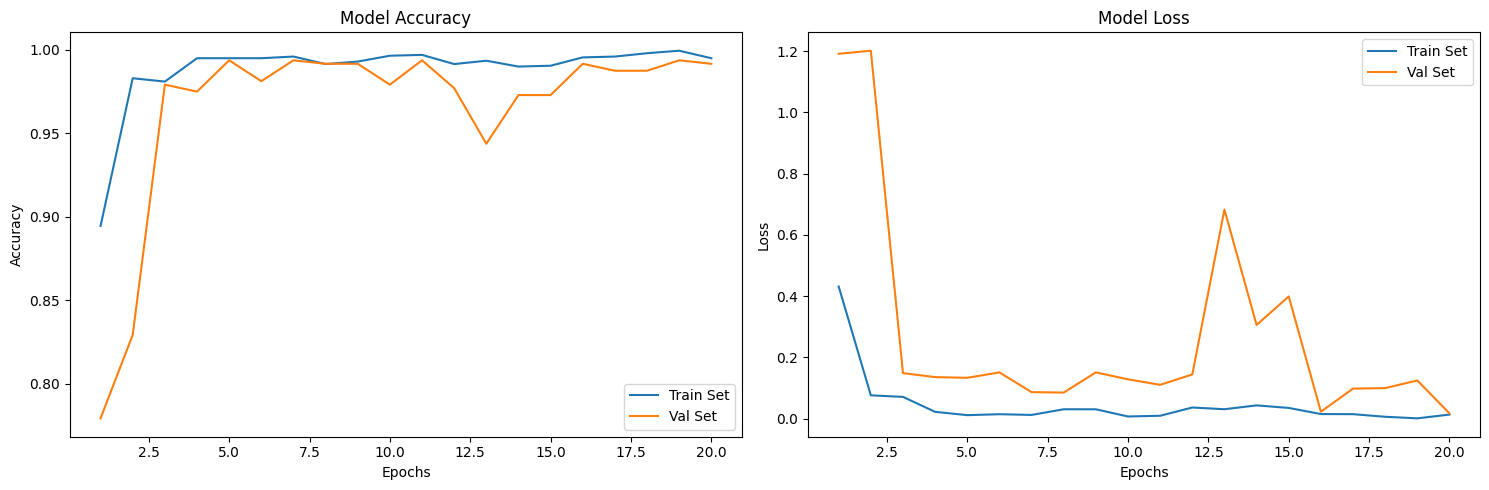

In [22]:
# plot model performance
acc = efficientnet_history.history['accuracy']
val_acc = efficientnet_history.history['val_accuracy']
loss = efficientnet_history.history['loss']
val_loss = efficientnet_history.history['val_loss']
epochs_range = range(1, len(efficientnet_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# model save

In [31]:
efficientnet.save('/kaggle/working/efficientnet_brain_tumor_model.h5')

# Load model

In [35]:
efficientnet = load_model('/kaggle/input/efficientnet-brain-tumor-model/efficientnet_brain_tumor_model.h5')

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 474ms/step
Validation Accuracy = 99.33


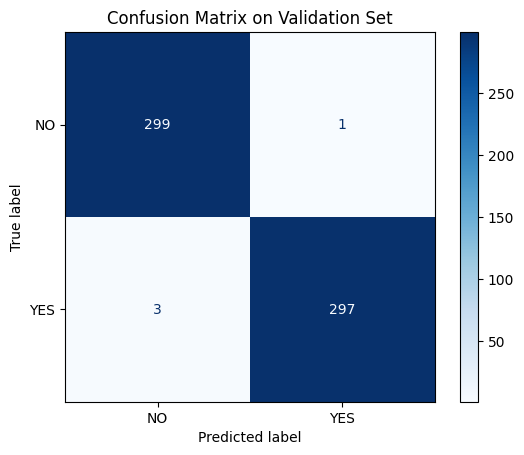

In [84]:
# validate on val set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Make predictions
predictions = efficientnet.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f' % (accuracy * 100))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step
Test Accuracy = 0.995000


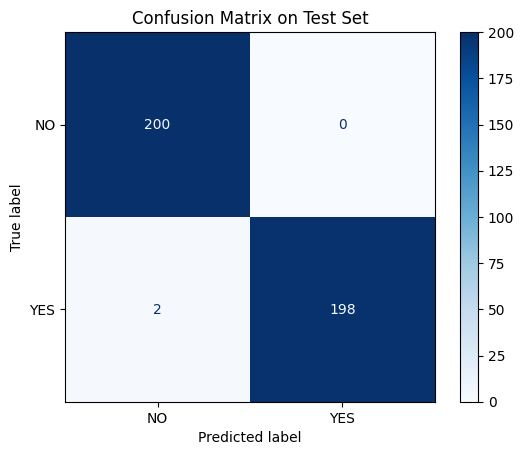

In [85]:
# validate on test set
predictions = efficientnet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %2f' % accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

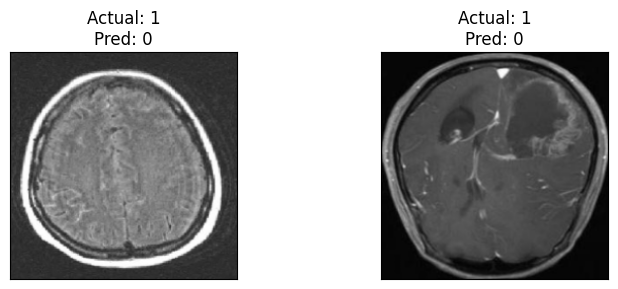

In [86]:
# Get indices of misclassified images
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    num_images = len(ind_list)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division to get row count

    plt.figure(figsize=(15, rows * 3))  # Adjust height as needed

    for idx, i in enumerate(ind_list):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual: {y_test[i]}\nPred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

# Densenet169

In [5]:
import tensorflow.keras.layers as L
from tensorflow.keras.applications import DenseNet169

NUM_CLASSES = 1

densenet = tf.keras.Sequential([
    DenseNet169(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
])

densenet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

densenet.summary()

I0000 00:00:1748452437.587399      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 1664)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1664)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,665 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,644,545 (48.24 MB)

 Trainable params: 12,486,145 (47.63 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [33]:
import time

start = time.time()

densenet_history = densenet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)


end = time.time()
print(end - start)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - accuracy: 0.7925 - loss: 0.9206 - val_accuracy: 0.4812 - val_loss: 42.9573
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 711ms/step - accuracy: 0.9512 - loss: 0.1939 - val_accuracy: 0.4938 - val_loss: 15.5216
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 720ms/step - accuracy: 0.9814 - loss: 0.0602 - val_accuracy: 0.5917 - val_loss: 10.3383
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 719ms/step - accuracy: 0.9938 - loss: 0.0276 - val_accuracy: 0.7542 - val_loss: 4.1305
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 697ms/step - accuracy: 0.9905 - loss: 0.0332 - val_accuracy: 0.7688 - val_loss: 2.5088
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 711ms/step - accuracy: 0.9867 - loss: 0.0315 - val_accuracy: 0.9250 - val_loss: 0.7312
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 706ms/step - accuracy: 0.9867 - loss: 0.0409 - val_accuracy: 0.9312 - val_loss: 0.3932
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 688ms/step - accuracy: 0.9943 - loss: 0.0154 - val_acc

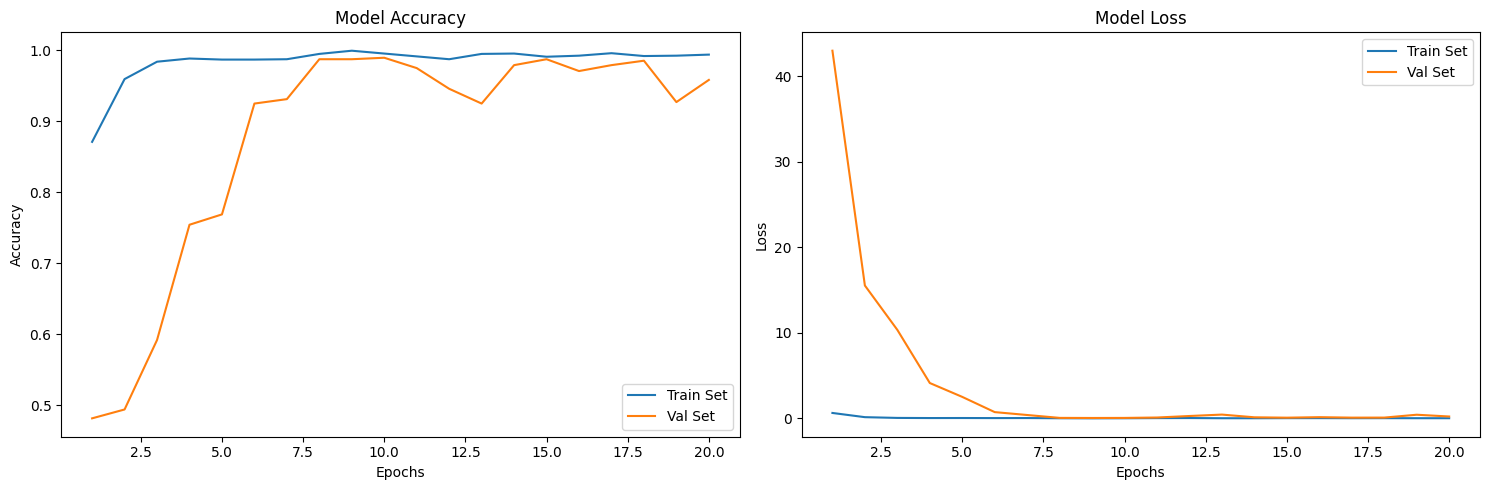

In [34]:
# plot model performance
acc = densenet_history.history['accuracy']
val_acc = densenet_history.history['val_accuracy']
loss = densenet_history.history['loss']
val_loss = densenet_history.history['val_loss']
epochs_range = range(1, len(densenet_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# model save

In [35]:
densenet.save('/kaggle/working/densenet169_brain_tumor_model.h5')

# load model

In [28]:
densenet = load_model('/kaggle/input/densenet169-brain-tumor-model/densenet169_brain_tumor_model.h5')  # Replace with your actual path

19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
Validation Accuracy = 96.33%


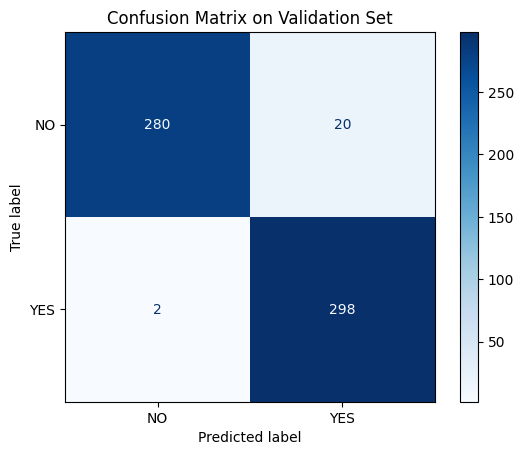

In [30]:
# validate on val set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Make predictions
predictions = densenet.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f%%' % (accuracy * 100))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Test Accuracy = 0.96


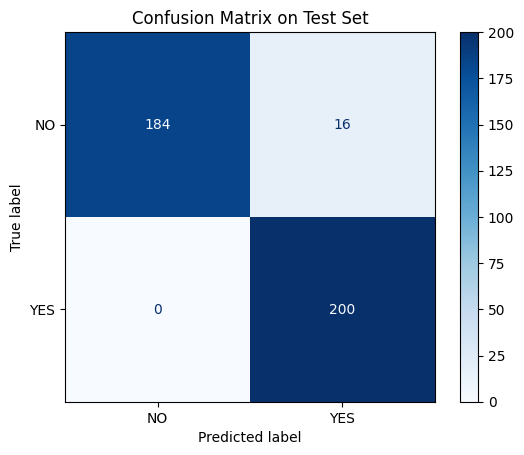

In [31]:
# validate on test set
predictions = densenet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()



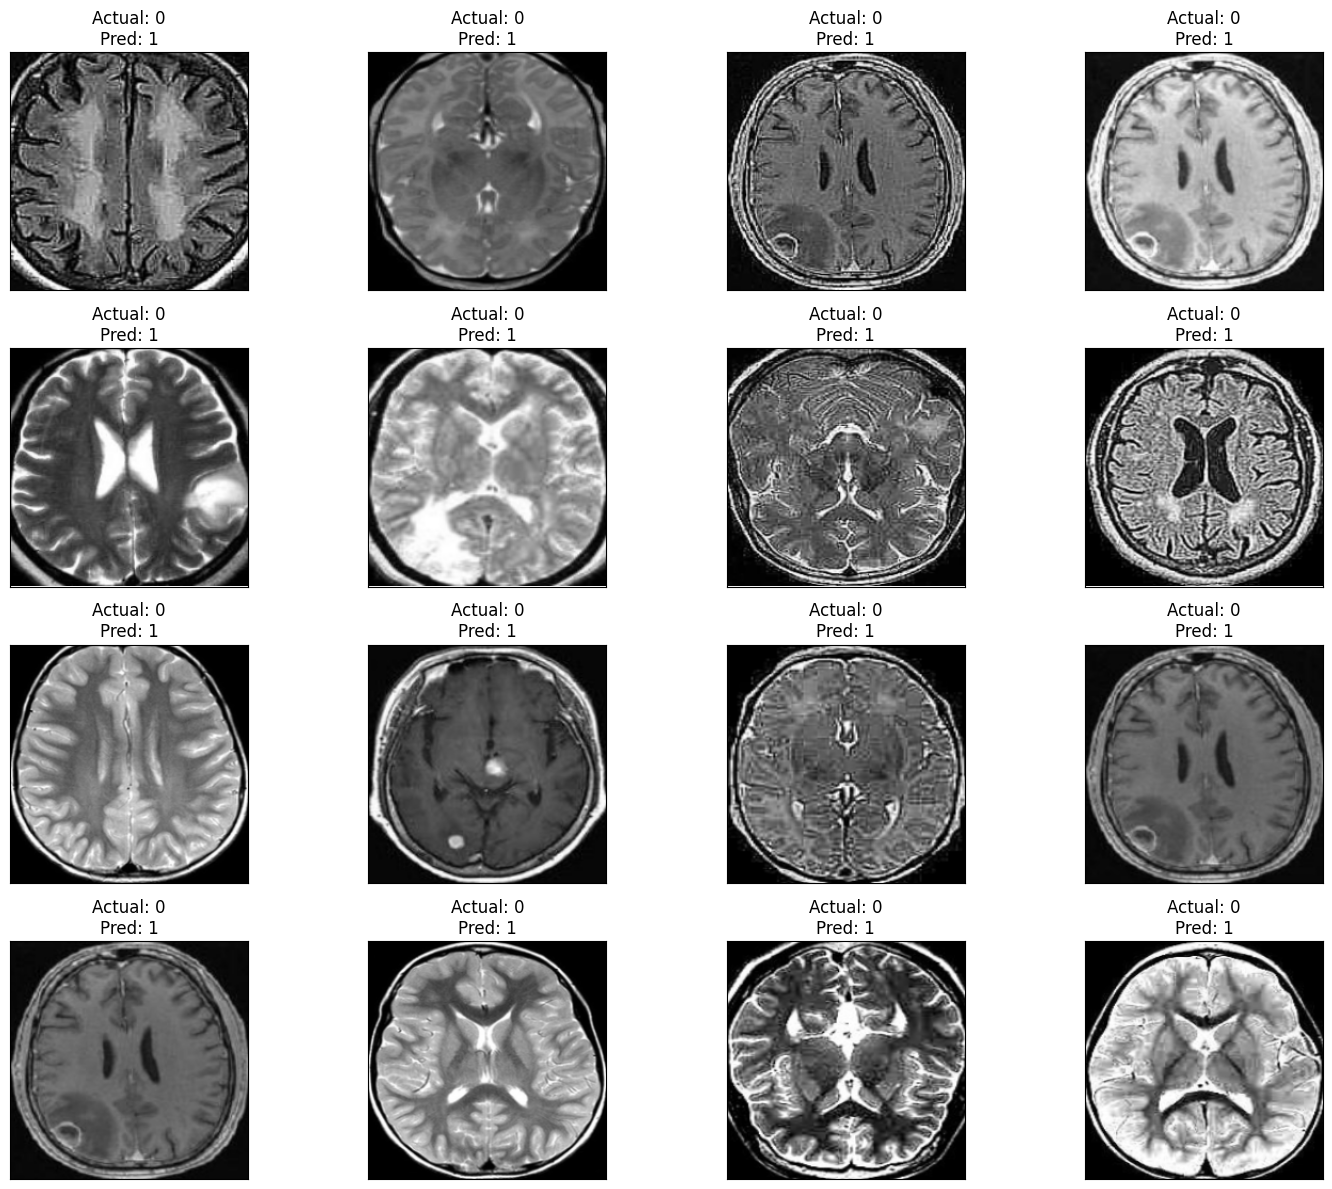

In [33]:
# Get indices of misclassified images
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    num_images = len(ind_list)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division to get row count

    plt.figure(figsize=(15, rows * 3))  # Adjust height as needed

    for idx, i in enumerate(ind_list):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual: {y_test[i]}\nPred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

# Xception Model

In [6]:
import tensorflow.keras.layers as L
from tensorflow.keras.applications import Xception

NUM_CLASSES = 1

xception = tf.keras.Sequential([
    Xception(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
])

xception.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

xception.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [44]:
import time 

start = time.time()

xception_history = xception.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/20


E0000 00:00:1748421205.032609     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748421205.251341     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-28 08:33:26.790243: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,728,28,28]{3,2,1,0}, f32[64,728,28,28]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-28 08:33:26.809964: E exter

 7/32 ━━━━━━━━━━━━━━━━━━━━ 16s 663ms/step - accuracy: 0.6414 - loss: 0.7300

E0000 00:00:1748421230.540707     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748421230.737000     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748421231.446466     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748421231.631361     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748421232.234757     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

32/32 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8185 - loss: 0.4065 - val_accuracy: 0.5542 - val_loss: 3.7166
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 725ms/step - accuracy: 0.9567 - loss: 0.1268 - val_accuracy: 0.7000 - val_loss: 3.8368
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 759ms/step - accuracy: 0.9947 - loss: 0.0170 - val_accuracy: 0.7521 - val_loss: 1.8246
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 743ms/step - accuracy: 0.9875 - loss: 0.0270 - val_accuracy: 0.9417 - val_loss: 0.5975
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 740ms/step - accuracy: 0.9969 - loss: 0.0121 - val_accuracy: 0.9771 - val_loss: 0.0773
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 749ms/step - accuracy: 0.9966 - loss: 0.0146 - val_accuracy: 0.9896 - val_loss: 0.0523
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 766ms/step - accuracy: 0.9955 - loss: 0.0127 - val_accuracy: 0.9812 - val_loss: 0.0904
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 732ms/step - accuracy: 0.9973 - loss: 0.0125 - val_accuracy: 0.9833 

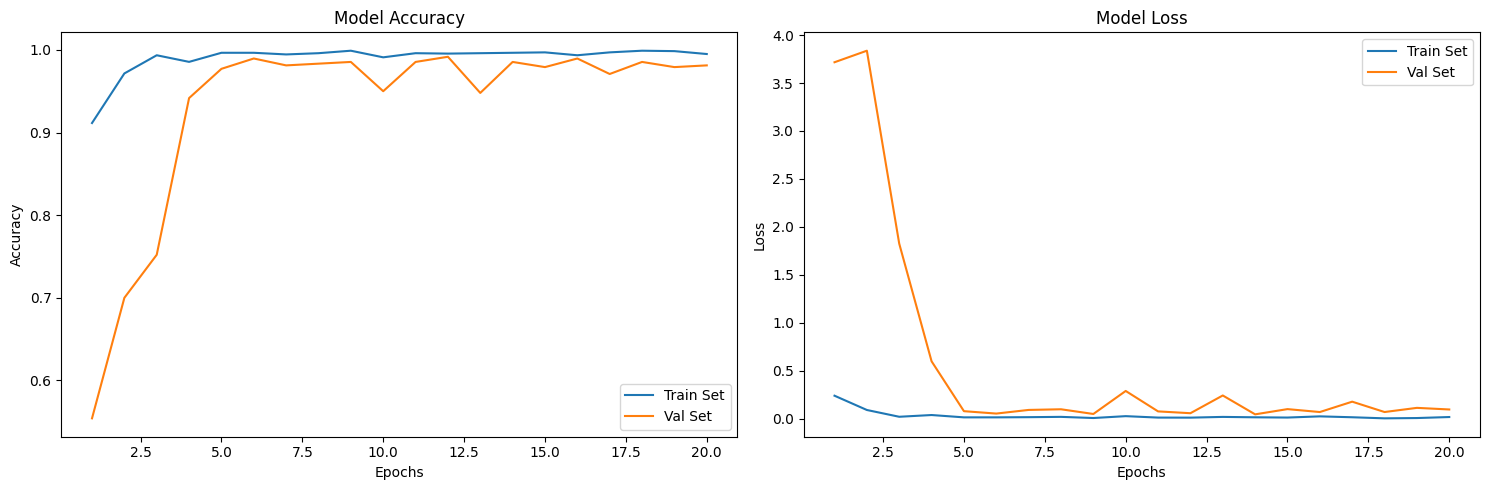

In [45]:
# plot model performance
acc = xception_history.history['accuracy']
val_acc = xception_history.history['val_accuracy']
loss = xception_history.history['loss']
val_loss = xception_history.history['val_loss']
epochs_range = range(1, len(xception_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


# Model save

In [49]:
xception.save('/kaggle/working/xception_brain_tumor_model.h5')

# Load model

In [ ]:
xception = load_model('/kaggle/input/xception-brain-tumor-model/xception_brain_tumor_model.h5') 

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step
Validation Accuracy = 98.00%


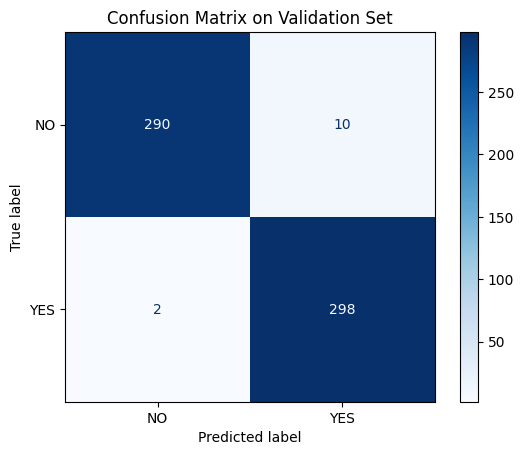

In [46]:
# validate on val set

# Make predictions
predictions = xception.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f%%' % (accuracy * 100))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step
Test Accuracy = 0.98


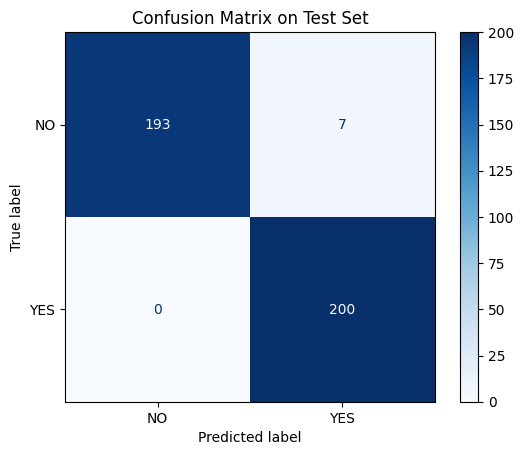

In [47]:
# validate on test set
predictions = xception.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

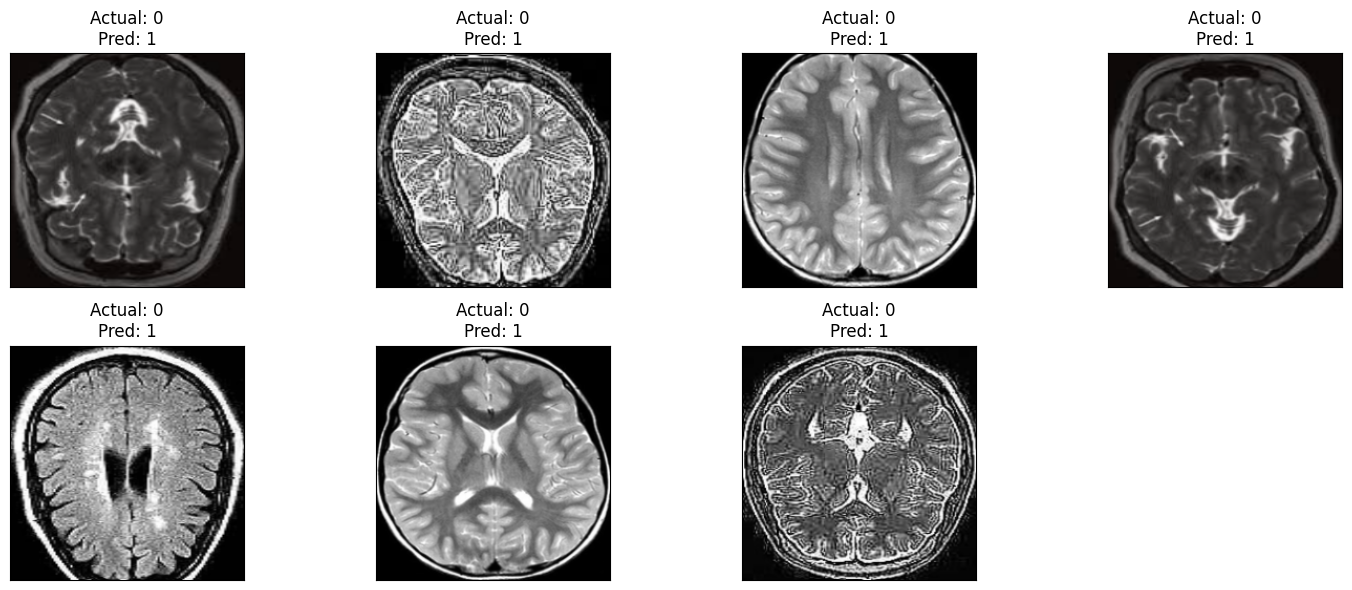

In [48]:
# Get indices of misclassified images
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    num_images = len(ind_list)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division to get row count

    plt.figure(figsize=(15, rows * 3))  # Adjust height as needed

    for idx, i in enumerate(ind_list):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual: {y_test[i]}\nPred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

# InceptionResNetV2 Model

In [7]:
from tensorflow.keras.applications import InceptionResNetV2

NUM_CLASSES = 1

inceptionresnet = tf.keras.Sequential([
    InceptionResNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
])

inceptionresnet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

inceptionresnet.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 1536)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,338,273 (207.28 MB)

 Trainable params: 54,277,729 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [73]:
import time

start = time.time()

inceptionresnet_history = inceptionresnet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.8418 - loss: 0.5917 - val_accuracy: 0.4958 - val_loss: 1246.0142
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 751ms/step - accuracy: 0.9570 - loss: 0.1572 - val_accuracy: 0.4917 - val_loss: 82.3309
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 723ms/step - accuracy: 0.9892 - loss: 0.0313 - val_accuracy: 0.9042 - val_loss: 0.9494
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 727ms/step - accuracy: 0.9938 - loss: 0.0265 - val_accuracy: 0.8729 - val_loss: 1.0136
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 752ms/step - accuracy: 0.9935 - loss: 0.0182 - val_accuracy: 0.9875 - val_loss: 0.0877
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 720ms/step - accuracy: 0.9987 - loss: 0.0080 - val_accuracy: 0.9812 - val_loss: 0.0944
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 732ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9875 - val_loss: 0.0598
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 732ms/step - accuracy: 0.9950 - loss: 0.0274 - val_ac

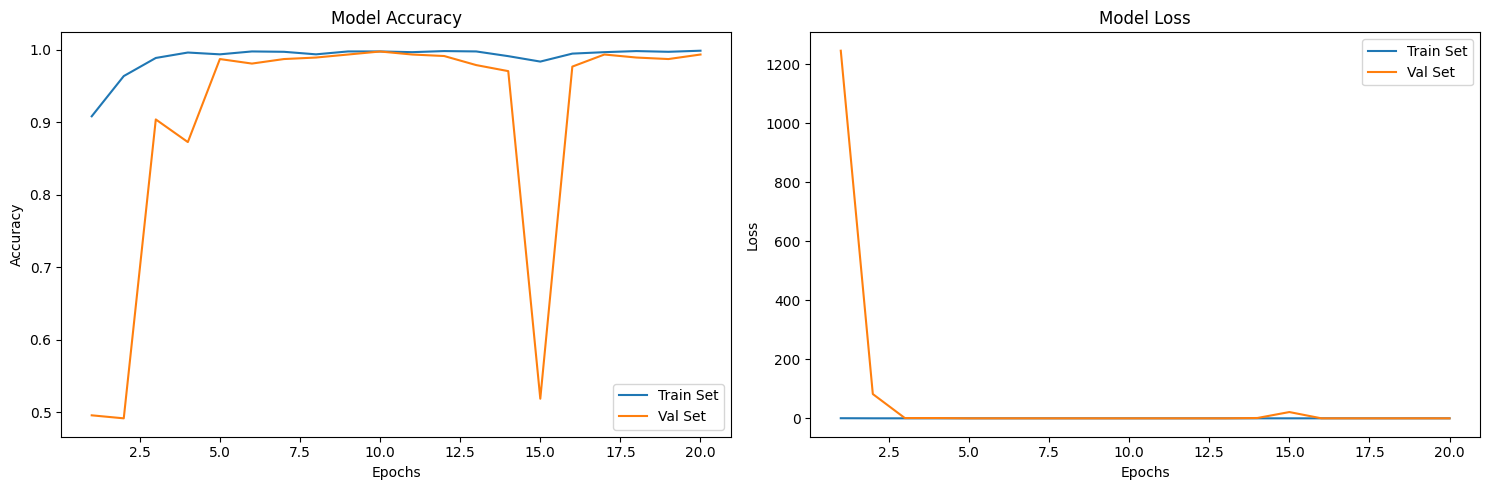

In [74]:
# plot model performance
acc = inceptionresnet_history.history['accuracy']
val_acc = inceptionresnet_history.history['val_accuracy']
loss = inceptionresnet_history.history['loss']
val_loss = inceptionresnet_history.history['val_loss']
epochs_range = range(1, len(inceptionresnet_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# model save

In [83]:
inceptionresnet.save('/kaggle/working/inceptionresnet_brain_tumor_model.h5')

# load model

In [ ]:
inceptionresnet = load_model('/kaggle/input/inceptionresnet-brain-tumor-model/inceptionresnet_brain_tumor_model.h5') 

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Validation Accuracy = 99.333333


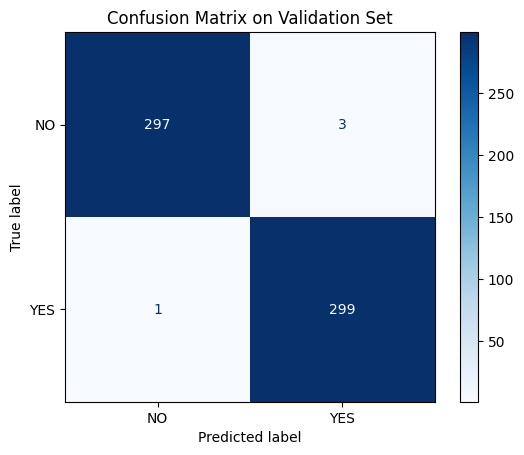

In [78]:
# validate on val set

# Make predictions
predictions = inceptionresnet.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %2f' % (accuracy * 100))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Validation Set")
plt.grid(False)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step
Test Accuracy = 0.992500


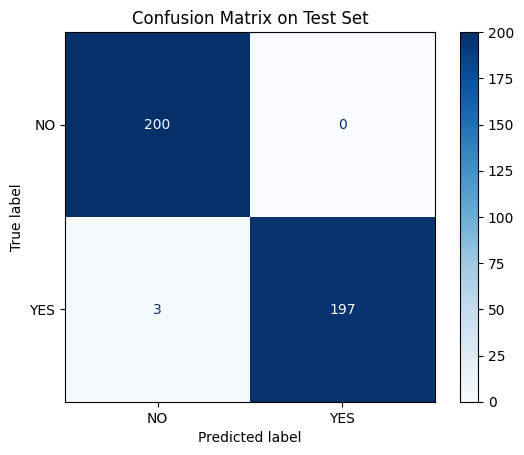

In [79]:
# validate on test set
predictions = inceptionresnet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %2f' % accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# If your 'labels' dictionary looks like {0: 'No Tumor', 1: 'Tumor'}, pass values:
labels_display = list(labels.values())  # e.g., ['No Tumor', 'Tumor']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

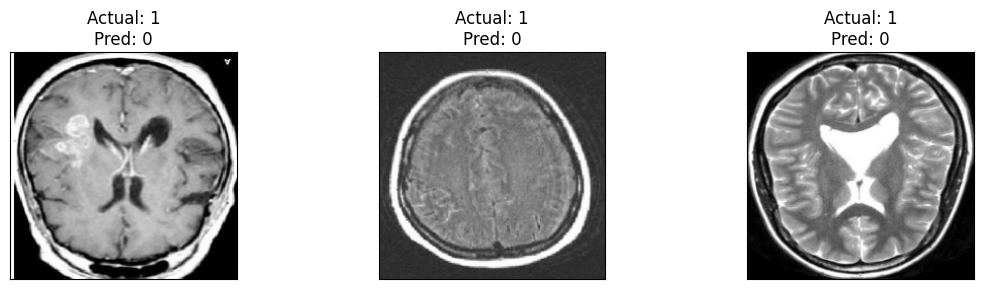

In [82]:
# Get indices of misclassified images
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    num_images = len(ind_list)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division to get row count

    plt.figure(figsize=(15, rows * 3))  # Adjust height as needed

    for idx, i in enumerate(ind_list):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual: {y_test[i]}\nPred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

# **Test single model**

# Single Image Prediction with EfficientNetB2

In [87]:
def Tumor_or_Not(x):
    return 'no' if x < 0.5 else 'yes'

image_path = '/kaggle/input/brain-tumor-detection/yes/y1013.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
image = tf.expand_dims(image, axis=0)  # Add batch dimension

pred = efficientnet.predict(image)[0][0]
print(Tumor_or_Not(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
yes


# Multiple Predictions from test_dataset with Visualization

In [28]:
TEST_DIR_predict = 'TEST_CROP/'

test_generator_predict = test_datagen.flow_from_directory(
    TEST_DIR_predict,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 400 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


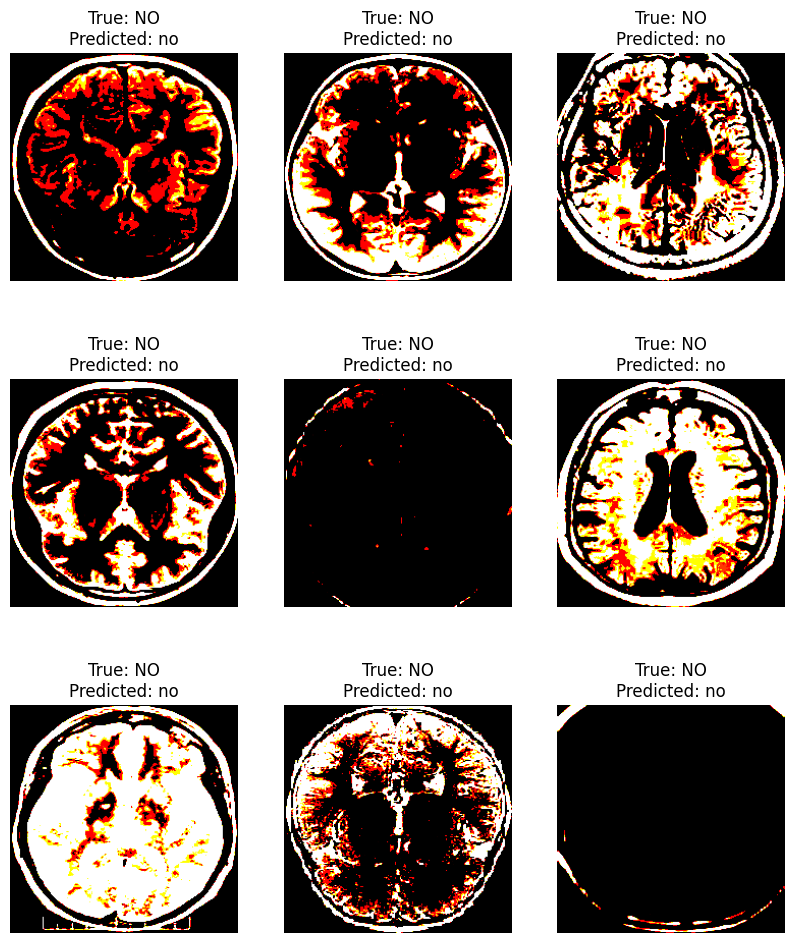

In [107]:
class_names = list(test_generator_predict.class_indices.keys())

plt.figure(figsize=(10, 12))

for i in range(9):
    image, label = test_generator_predict[i]  # (image.shape = (1, 224, 224, 3)), (label.shape = (1,))
    img = image[0]
    true_label = label[0]

    pred = efficientnet.predict(tf.expand_dims(img, axis=0))[0][0]

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[int(true_label)]}\nPredicted: {Tumor_or_Not(pred)}")
    plt.axis('off')